# Smarter HP Search for Muon Iterators Part 2

by Franz Louis Cesista

## Prepare environment

### Import libraries

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import sympy as sp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

### Prepare sympy symbols or symbolic proofs/manipulation later on

In [2]:
gamma_ = sp.Symbol("gamma", interval=(5/4, sp.S.Infinity), left_open=True, right_open=True)
l_ = sp.Symbol("l", interval=(0, 1), left_open=False, right_open=True)
r_ = sp.Symbol("r", interval=(0, 1), left_open=False, right_open=True)
x_ = sp.Symbol("x", real=True)

# We want to estimate sign(M) +- epsilon
fp_ = [1 - l_, 1 + r_, 0, -(1 + r_), -(1 - l_)]
iterator_ = x_ + gamma_ * (x_ - fp_[0])*(x_ - fp_[1])*(x_ - fp_[2])*(x_ - fp_[3])*(x_ - fp_[4])
iterator_simplified_ = sp.collect(sp.expand(iterator_), x_)

dhdx_ = sp.simplify(sp.expand(sp.diff(iterator_simplified_, x_, real=True)))
dhdx_ = dhdx_.refine(sp.Q.real(x_)).refine(sp.Q.real(gamma_)).refine(sp.Q.real(l_)).refine(sp.Q.real(r_))
dhdx_ = sp.collect(sp.simplify(dhdx_), x_)

In [3]:
iterator_jax = sp.lambdify((x_, gamma_, l_, r_), iterator_simplified_, "jax")
dhdx_jax = sp.lambdify((x_, gamma_, l_, r_), dhdx_, "jax")

### Prepare iterators

#### Keller Jordan's iterator

In [4]:
keller_jordan_iterator_ = 3.4445*x_ - 4.7750*x_**3 + 2.0315*x_**5
keller_jordan_iterator_

2.0315*x**5 - 4.775*x**3 + 3.4445*x

In [5]:
kj_roots = sorted(sp.nroots(keller_jordan_iterator_ - x_))
kj_roots

[-1.26372906729838, -0.868025797655531, 0, 0.868025797655531, 1.26372906729838]

In [6]:
kj_gamma = 2.0315
kj_inner_radius = 1 - kj_roots[-2]
kj_outer_radius = kj_roots[-1] - 1
kj_inner_radius, kj_outer_radius

(0.131974202344469, 0.263729067298377)

In [7]:
kj_div_at_0 = dhdx_jax(0, kj_gamma, kj_inner_radius, kj_outer_radius)
kj_div_at_0, kj_div_at_0**5

(3.44450000000000, 484.876287100183)

In [8]:
keller_jordan_iterator_jax = sp.lambdify(x_, keller_jordan_iterator_, "jax")

#### Maximum variance iterator

In [9]:
mv_gamma = 1.1184906005859376
mv_inner_radius = 0
mv_outer_radius = 0.7

In [10]:
iterator_simplified_.subs({gamma_: mv_gamma, l_: mv_inner_radius, r_: mv_outer_radius})

1.11849060058594*x**5 - 4.3509284362793*x**3 + 4.23243783569336*x

In [11]:
mv_div_at_0 = dhdx_jax(0, mv_gamma, mv_inner_radius, mv_outer_radius)
mv_div_at_0, mv_div_at_0**4

(4.23243783569336, 320.8945582435044)

In [12]:
mv_iterator_jax = sp.lambdify(x_, iterator_simplified_.subs({gamma_: mv_gamma, l_: mv_inner_radius, r_: mv_outer_radius}), "jax")

### Utils

In [148]:
SLOPE_WEIGHT = 3.55e-4

def loss_util(x, params):
    def scan_fn(y, gamma_r):
        gamma, l, r = gamma_r
        y = iterator_jax(y, gamma, l, r)
        return y, r
    y, _ = jax.lax.scan(scan_fn, x, params)
    loss1 = jnp.sqrt(jnp.mean((y - 1) ** 2))

    slopes = dhdx_jax(0, params[:, 0], params[:, 1], params[:, 2])
    # loss2 = SLOPE_WEIGHT * jnp.clip((3.4445**5 - slopes.prod()), 0)
    # mv_div_at_0^4 is the maximum attainable slope at 0 after 4 iterations
    loss2 = SLOPE_WEIGHT * jnp.clip((mv_div_at_0**4 - slopes.prod()), 0)

    # loss3 = jnp.clip(jnp.max(y - 1.2023681), 0)

    # return loss1, loss2, loss3
    return loss1, loss2


def loss(x, params):
    # loss1, loss2, loss3 = loss_util(x, params)
    loss1, loss2 = loss_util(x, params)
    # return loss1 + loss2 + loss3
    return loss1 + loss2


loss_grad_fn = jax.jit(jax.grad(loss, argnums=1))
loss_and_grad_fn = jax.jit(jax.value_and_grad(loss, argnums=1))

In [149]:
@partial(jax.jit, static_argnums=(2,3))
def train(
    x: jnp.ndarray,
    params: jnp.ndarray,
    learning_rate: float = 0.001,
    num_steps: int = 10,
):
    optimizer = optax.chain(
        optax.adam(learning_rate=learning_rate),
        optax.clip_by_global_norm(max_norm=1.0),
    )
    opt_state = optimizer.init(params)

    def body_fn(values: tuple[jnp.ndarray, optax.OptState], _):
        params, opt_state = values
        loss, grad = loss_and_grad_fn(x, params)
        updates, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        return (params, opt_state), loss

    (params, _), losses = jax.lax.scan(body_fn, (params, opt_state), length=num_steps)

    return params, losses

## Main body

Prepare inputs. We want to pay more attention to smaller values of $x$.

In [150]:
x = jnp.concat([
    jnp.linspace(0, 1, 1000),
    jnp.linspace(0, 0.1, 1000),
    jnp.linspace(0, 0.01, 1000),
])

Initialize parameters

In [151]:
key = jax.random.PRNGKey(0)

params = jnp.array([[1, float(kj_inner_radius), float(kj_outer_radius)]]*4)

noised_params = params
key, subkey = jax.random.split(key)
noised_params = noised_params.at[:,1:].add(jax.random.uniform(subkey, noised_params[:,1:].shape, minval=-0.1, maxval=0.1))
key, subkey = jax.random.split(key)
noised_params = noised_params.at[:,:1].add(jax.random.uniform(subkey, noised_params[:,:1].shape, minval=-1, maxval=1))

### Train

In [181]:
new_params, losses = train(x, noised_params, learning_rate=0.001, num_steps=21250)
new_params.shape, losses.shape

((4, 3), (21250,))

### Check training results

In [182]:
kj_div_at_0**5, mv_div_at_0**4, dhdx_jax(0, new_params[:, 0], new_params[:, 1], new_params[:, 2]).prod()

(484.876287100183, 320.8945582435044, Array(278.45276, dtype=float32))

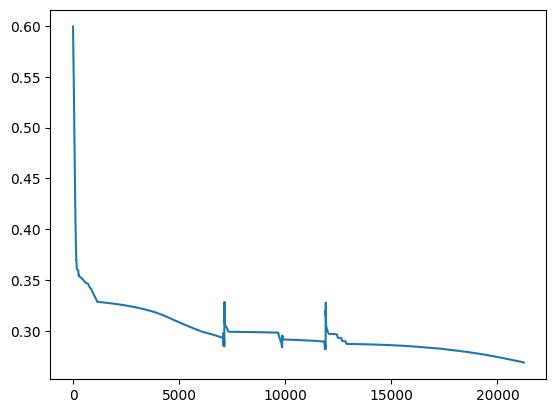

In [183]:
plt.plot(losses)

In [184]:
loss(x, params), loss(x, new_params)

(Array(0.67761326, dtype=float32), Array(0.26849517, dtype=float32))

### Coefficients

In [185]:
params, noised_params, new_params

(Array([[1.        , 0.1319742 , 0.26372907],
        [1.        , 0.1319742 , 0.26372907],
        [1.        , 0.1319742 , 0.26372907],
        [1.        , 0.1319742 , 0.26372907]], dtype=float32),
 Array([[0.94732   , 0.13676813, 0.22279383],
        [1.5720949 , 0.16242138, 0.3250962 ],
        [1.7612047 , 0.05603141, 0.29532978],
        [0.7666786 , 0.12500212, 0.32969922]], dtype=float32),
 Array([[8.1059303e+00, 3.7724969e-01, 1.9567152e-02],
        [6.1726108e+00, 3.6625630e-01, 8.6106412e-02],
        [7.8289165e+00, 3.6086357e-01, 5.3700381e-03],
        [4.1197319e+00, 1.7549871e-01, 2.2484643e-02]], dtype=float32))

In [196]:
for gamma, l, r in new_params:
    curr_iterator_ = iterator_simplified_.subs({gamma_: gamma, l_: l, r_: r})
    pkj = sp.Poly(curr_iterator_, x_)
    print([round(v, 4) for v in pkj.coeffs()][::-1])

[4.2679, -11.5699, 8.1059]
[3.9244, -9.7605, 6.1726]
[4.2325, -11.1113, 7.8289]
[3.9280, -7.1077, 4.1197]


## Viz

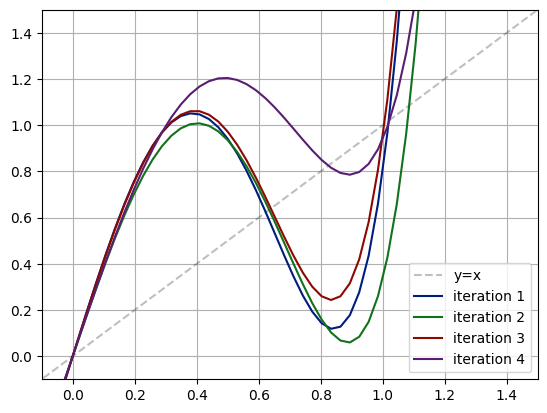

In [187]:
x_space = jnp.linspace(-(1 + 0.5), 1 + 0.5, 100)

palette = sns.color_palette("dark6")

sns.lineplot(x=x_space, y=x_space, label='y=x', color="black", linestyle="--", alpha=0.25)

for idx, (gamma, l, r) in enumerate(new_params):
    my_iterator_jax = sp.lambdify(
        x_,
        iterator_simplified_.subs({gamma_: gamma, l_: l, r_: r}),
        "jax",
    )
    y_ = my_iterator_jax(x_space)
    sns.lineplot(x=x_space, y=y_, label=f"iteration {idx+1}", color=palette[idx])

plt.xlim(-(0.1), 1 + 0.5)
plt.ylim(-(0.1), 1 + 0.5)
plt.grid()
plt.legend(loc="lower right")
plt.savefig("img/iterator_attractor_basin.png")

In [188]:
y0 = x
for _ in range(5):
    y0 = keller_jordan_iterator_jax(y0)


def scan_fn(y, gamma_r):
    gamma, l, r = gamma_r
    y = iterator_jax(y, gamma, l, r)
    return y, y


y1, _ = jax.lax.scan(scan_fn, x, params)
y2, _ = jax.lax.scan(scan_fn, x, new_params)

y3 = x
for _ in range(4):
    y3 = mv_iterator_jax(y3)

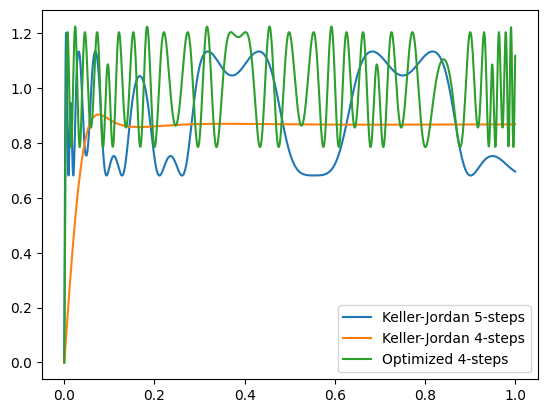

In [189]:
sns.lineplot(x=x, y=y0, label="Keller-Jordan 5-steps")
sns.lineplot(x=x, y=y1, label="Keller-Jordan 4-steps")
# sns.lineplot(x=x, y=y3, label="Max $\gamma$ 4-steps")
sns.lineplot(x=x, y=y2, label="Optimized 4-steps")
plt.legend(loc="lower right")

(-0.1, 1.5)

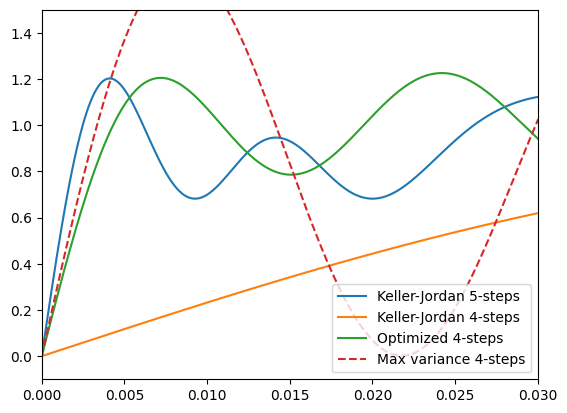

In [190]:
sns.lineplot(x=x, y=y0, label="Keller-Jordan 5-steps")
sns.lineplot(x=x, y=y1, label="Keller-Jordan 4-steps")
sns.lineplot(x=x, y=y2, label="Optimized 4-steps")
sns.lineplot(x=x, y=y3, label="Max variance 4-steps", linestyle="--")
plt.xlim(0, 0.03)
plt.ylim(-0.1, 1.5)

In [191]:
min_idx = jnp.argmax(y2[:1000]).item()
jnp.max(y2) / jnp.min(y2[min_idx:1000])

Array(1.5599471, dtype=float32)